# 1. Дизайн эксперимента


Необходимо опредлиться с гипотезами.
Посколько мы заранее не имеем представления о том, будет ли новый новый вариант работы сервиса svm_ensemble_v_1_22 лучше или хуже чем текущий вариант standart, мы выбираем двусторонний статистический тест.

Нулевая гипотеза H0 : p  = p0

Альтернативная гипотеза H  : p != p0

где p и p0 означают коэффициенты конверсии между новым и старым вариантами соответственно. Принимаем уровень доверия (confidence level) 95%.
Показатель альфа будет равен (1 - 0.95) для нашего теста = 0.05.

Для проведения A/B тестирования необходимо 2 группы испытемых:
1. Контрольная (Control) группа - та группа пользователей, которым будет показываться вариант сервиса standard.
2. Эксперементальная (Treatment) группа - та группа пользователей, которым будет показываться новый вариант сервиса svm_ensemble_v_1_22.

Нашей целевой переменной (Dependant Variable) будет выступать - уровень конверсии (conversion_rate). Целевая переменная представленна бинарно:
0 - пользователь не купил ничего в течение своей сессии на сайте
1 - пользователь купил продукт в течение своей сессии на сайте

In [34]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

In [35]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 14}
mpl.rc('font', **font)

# 2. Сбор данных и их подготовка


In [36]:
df = pd.read_csv('./ab_test_ensembles.csv', index_col=False, parse_dates=['timestamp'])

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    294478 non-null  object        
 1   timestamp  294478 non-null  datetime64[ns]
 2   group      294478 non-null  object        
 3   variants   294478 non-null  object        
 4   converted  294478 non-null  int64         
 5   location   294478 non-null  object        
 6   age_group  294478 non-null  object        
 7   user_type  294478 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 18.0+ MB


In [38]:
df.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user


In [39]:
df.isnull().sum()

user_id      0
timestamp    0
group        0
variants     0
converted    0
location     0
age_group    0
user_type    0
dtype: int64

In [40]:
pd.crosstab(df['group'], df['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


In [41]:
sessions = df['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в нашей выборке.")

У нас имеются 0 пользователей, которые не уникальны в нашей выборке.


Дубликатов нет

In [42]:
ab_df = df

In [43]:
ab_df.group.value_counts(normalize=True)

treatment    0.500126
control      0.499874
Name: group, dtype: float64

# 3. Визуализация Результатов Эксперимента

Сначала рассчитываем выборочные статистики, чтобы понять каково распределение данных и как выглядят наши выборки.

In [46]:
def get_conversion_rates(ab_df):
    conversion_rates = ab_df.groupby('group')['converted']
    # Стандартное отклонение для сформированной выборки
    std_proportion = lambda x: np.std(x, ddof=0)
    # Стандартная ошибка для сформированной выборки, формулу стандартной ошибки вы знаете из лекций. Забыли - погуглите.
    se_proportion = lambda x: stats.sem(x, ddof=0)

    return conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})

get_conversion_rates(ab_df)

,CR mean,CR std,CR se
group,,,
control,0.120399,0.325428,0.000848
treatment,0.118920,0.323694,0.000843


Два эксперимента +/- по выборочным статистикам показывают себя одинаково, выборочный средний коэффициент конверсии ~12.0% против ~11.9%

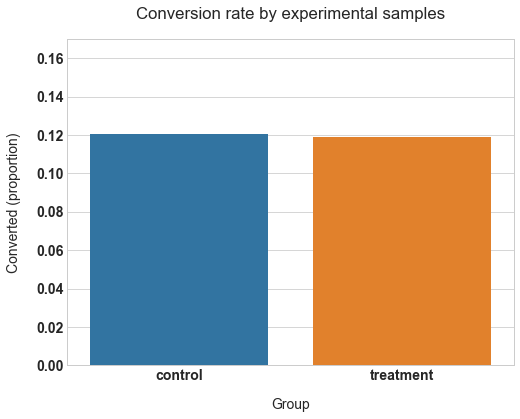

In [47]:
def plot_conversion(ab_df, title):
    plt.figure(figsize=(8,6));
    sns.barplot(x=ab_df['group'], y=ab_df['converted'], ci=False);
    plt.ylim(0, 0.17);
    plt.title(title, pad=20)
    plt.xlabel('Group', labelpad=15);
    plt.ylabel('Converted (proportion)', labelpad=15);

plot_conversion(ab_df, 'Conversion rate by experimental samples')

# 4. Тестирование гипотезы

Используем нормальную аппроксимацию. Рассчитываем Z-статистику, p-value и доверительные интервалы для каждой группы

In [61]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

def hypothesis_testing(ab_df):
    control_results = ab_df[ab_df['group'] == 'control']['converted']
    treatment_results = ab_df[ab_df['group'] == 'treatment']['converted']

    n_con = control_results.count()
    n_treat = treatment_results.count()
    successes = [control_results.sum(), treatment_results.sum()]
    nobs = [n_con, n_treat]

    z_stat, pval = proportions_ztest(successes, nobs=nobs)
    (lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

    print(f'Z-statistic: {z_stat:.2f}')
    print(f'p-value: {pval:.3f}')
    print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
    print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')


hypothesis_testing(ab_df)   

Z-statistic: 1.24
p-value: 0.216
CI 95% for control group: [0.119, 0.122]
CI 95% for treatment group: [0.117, 0.121]


# 5. Интерпретация результатов

Так как полученное p-значение = 0.216, что является высоким показателем по сравнению с выбранной альфой 0.05, то согласно статистическому выводу, мы не можем отклонить нулевую гипотезу H0.
Значит наш новый вариант сервиса никак статистически значимо не влияет на уровень конверсии.

Доверительный интервал для испытуемой группы [0.117, 0.121] или 11.7% и 12.1% соответственно:
1. Он включает наш baseline
2. Он не достигает нашей цели 15%

Таким образом наиболее вероятно, что реальный уровень конверсии сайта с новым вариантом svm_ensemble_v_1_22 будет близок к baseline чем к 15%, который мы определили по нашей цели.

# 6. Выборка старые/новые пользователи. Тестирование гипотезы и интерпретация результатов

In [49]:
reg_user_df = df[df.user_type == 'registered_user']
new_user_df = df[df.user_type == 'new_user']

In [50]:
pd.crosstab(reg_user_df['group'], reg_user_df['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,72483,969
treatment,959,72829


In [51]:
pd.crosstab(new_user_df['group'], new_user_df['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,72791,959
treatment,1006,72482


#### Для старых пользователей

In [52]:
reg_ab_df = reg_user_df
reg_ab_df.group.value_counts(normalize=True)

treatment    0.501141
control      0.498859
Name: group, dtype: float64

In [53]:
get_conversion_rates(reg_ab_df)

,CR mean,CR std,CR se
group,,,
control,0.120051,0.325021,0.001199
treatment,0.120277,0.325285,0.001197


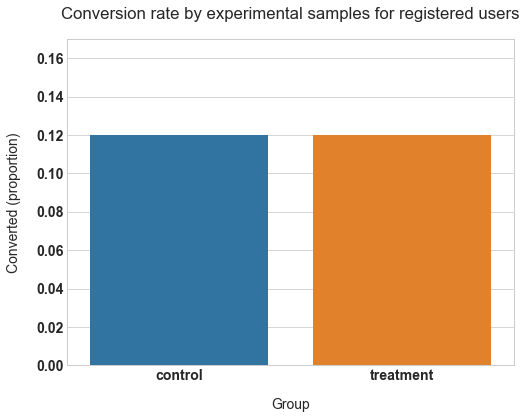

In [54]:
plot_conversion(reg_ab_df, 'Conversion rate by experimental samples for registered users')

In [56]:
hypothesis_testing(reg_ab_df)

Z-statistic: -0.13
p-value: 0.894
CI 95% for control group: [0.118, 0.122]
CI 95% for treatment group: [0.118, 0.123]


Для старых пользователей получили p-значение = 0.894, что является высоким показателем по сравнению с выбранной альфой 0.05, то согласно статистическому выводу, мы не можем отклонить нулевую гипотезу H0.
Значит наш новый вариант сервиса никак статистически значимо не влияет на уровень конверсии.

Доверительный интервал для испытуемой группы [0.118, 0.123] или 11.8% и 12.3% соответственно. Результаты соответствуют первому варианту расчета (для всех пользователей)

#### Для новых пользователей:

In [62]:
new_ab_df = new_user_df
new_ab_df.group.value_counts(normalize=True)

control      0.50089
treatment    0.49911
Name: group, dtype: float64

In [63]:
get_conversion_rates(new_ab_df)

,CR mean,CR std,CR se
group,,,
control,0.120746,0.325832,0.001200
treatment,0.117557,0.322082,0.001188


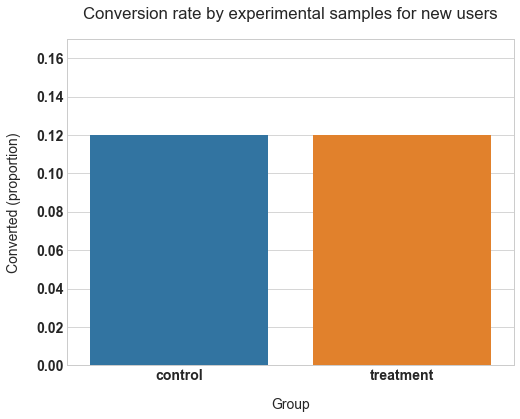

In [64]:
plot_conversion(reg_ab_df, 'Conversion rate by experimental samples for new users')

In [65]:
hypothesis_testing(new_ab_df)

Z-statistic: 1.89
p-value: 0.059
CI 95% for control group: [0.118, 0.123]
CI 95% for treatment group: [0.115, 0.120]


Для новых пользователей получили p-значение = 0.059, что немного выше выбранной альфой 0.05. Мы не можем отклонить нулевую гипотезу H0.
Значит наш новый вариант сервиса никак статистически значимо не влияет на уровень конверсии.

Доверительный интервал для испытуемой группы [0.115, 0.120] или 11.5% и 12.0% соответственно. Результаты соответствуют первому варианту расчета (для всех пользователей)